In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
from collections import Counter
# import pickle
# import numpy_groupies as npg
# from scipy.spatial.distance import minkowski
from time import perf_counter

### Functions

In [2]:
def get_images(name, size):
    images = np.empty((size, 784), dtype=np.int16)
    numbers = np.empty(size, dtype=np.int32)

    with open(name, 'rt') as file:
        for i in range(size):
            row = file.readline().split(',')

            numbers[i] = row[0]
            images[i] = row[1:]

    return numbers, images

def show_image(image):
    plt.imshow(image.reshape((28,28)), cmap='gray')
    plt.show()

def k_nearest_neighbour_old(image, numbers, images, k):
    sorted_indices = np.argsort(np.linalg.norm(images-image, axis=-1))
    return Counter(numbers[i] for i in sorted_indices[:k]).most_common(1)[0][0]

# Find k nearest neighbours
#   Take first k values and sort
#   Go over the rest and insert if its smaller than the maximum value
# Generate all smaller results

# def k_nearest_neighbours(train_images, test_image, k, dist_func):
#     '''Returns nearest k indices in order of closest'''
#     return np.argpartition(dist_func(train_images, test_image), range(1,k+1), axis=-1)[:k]

# neighbour_func = lambda x: k_nearest_neighbours(images_train_small, x, k_range, euclid_dist)
# arg_max_func = lambda k: np.argmax(npg.aggregate(numbers_train_small[list(map(neighbour_func, images_test_small[:2]))][:k], 1))
# result = list(map(arg_max_func, range(1,k_range+1)))

def euclid_dist(train_images, test_image):
    return np.linalg.norm(train_images-test_image, axis=-1)

def mink_dist(x, y, p):
    return np.linalg.norm(x - y, ord=p, axis=-1)



In [3]:
# MNIST_train 60000 images
# MNIST_test 10000 images
# MNIST_train_small 3000 images
# MNIST_test_small 1000 images

# 11 seconds for 60000 images
# images = get_images('data/MNIST_train.csv', 60000)
numbers_train_small, images_train_small = get_images('data/MNIST_train_small.csv', 3000)
numbers_test_small, images_test_small = get_images('data/MNIST_test_small.csv', 1000)

In [3]:
numbers_train, images_train = get_images('data/MNIST_train.csv', 60000)
numbers_test, images_test = get_images('data/MNIST_test.csv', 10000)

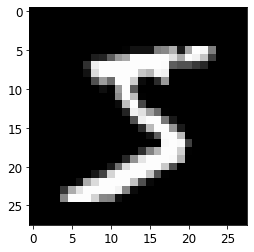

In [7]:
show_image(images_train[0])

In [8]:
def k_nearest_neighbours(train_images, train_numbers, test_image, k, dist_func):
    norm_list = dist_func(train_images, test_image)
    nearest_idx = np.empty(k, dtype=np.int32)
    common_nr = np.empty(k, dtype=np.int8)
    for i in range(k):
        min_idx = np.argmin(norm_list)
        norm_list[min_idx] = np.inf
        nearest_idx[i] = min_idx

        common_nr[i] = Counter(train_numbers[nearest_idx[:i+1]]).most_common(1)[0][0]

    return common_nr

In [6]:
k = 20
neighbour_func = lambda img: k_nearest_neighbours(images_train_small, numbers_train_small, img, k, euclid_dist)

In [7]:
# Train data compared with test data
test_common_nrs = np.array(list(map(neighbour_func, images_test_small))).transpose()

In [8]:
not_eq = lambda x,y: x != y

# Emprical risk on the test set
test_small_risk = np.sum(not_eq(test_common_nrs, numbers_test_small), axis=1)/numbers_test_small.shape[0]
print(test_small_risk)

[0.085 0.085 0.077 0.076 0.072 0.076 0.08  0.081 0.083 0.09  0.095 0.097
 0.098 0.103 0.103 0.105 0.104 0.111 0.112 0.113]


In [9]:
# Train data compared with train data
train_common_nrs = np.array(list(map(neighbour_func, images_train_small))).transpose()

In [10]:
# Emprical risk on the train set
train_small_risk = np.sum(not_eq(train_common_nrs, numbers_train_small), axis=1)/numbers_train_small.shape[0]
print(train_small_risk)

[0.         0.         0.02733333 0.027      0.04066667 0.04266667
 0.05133333 0.05333333 0.06233333 0.06266667 0.07066667 0.07033333
 0.07533333 0.07333333 0.08033333 0.08066667 0.08433333 0.083
 0.08466667 0.08566667]


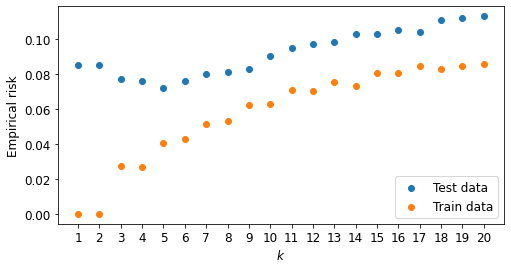

In [114]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(range(1,k+1), test_small_risk, label='Test data')
ax.scatter(range(1,k+1), train_small_risk, label='Train data')
ax.legend(loc=4)
ax.set_xlabel(r"$k$")
ax.set_ylabel("Empirical risk")
ax.xaxis.set_ticks(list(range(1,21)))

plt.savefig("Figures/ex_a_risk.pdf")
plt.show()

# Best k for this model is five!

In [245]:
" & ".join(list(str(i) for i in range(20)))

'0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 & 11 & 12 & 13 & 14 & 15 & 16 & 17 & 18 & 19'

### Function speed tests

In [9]:
norm_list = np.linalg.norm(images_train_small-images_test_small[0], axis=-1)
nearest_arr = np.empty(20)

In [7]:
%%timeit
for i in range(20):
    min_idx = np.argmin(norm_list)
    norm_list[min_idx] = np.inf
    nearest_arr[i] = min_idx

82.2 µs ± 489 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [14]:
%timeit np.argsort(norm_list)[:20]
%timeit np.argpartition(norm_list, range(1,21), axis=-1)[:20]

145 µs ± 895 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
77.2 µs ± 514 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [15]:
f = lambda x: x ** 2
uf = np.frompyfunc(f, 1, 1)
g = lambda x, y: x + y
x = np.arange(1000)
y = np.arange(1000)
vf = np.vectorize(f)

# f(x) 1.48 mirco s
# g(x,y) 1.33 micro s
# uf(x) 284 micro s
# vf(x) 313 micro s
# np.fromiter((f(i) for i in x), x.dtype, count=len(x)) 402 micro s
# np.array(list(map(f, x))) 442 micro s
# np.array([f(i) for i in x], dtype=x.dtype) 487 micro s
# normal for loop 511 micro s
# arr = np.empty(x.shape)
# for i in range(x.size):
#   arr[i] = f(x[i])

In [11]:
nearest_arr = np.argsort(norm_list)[:20]

In [14]:
%timeit np.argmax(npg.aggregate(numbers_train_small[nearest_arr], 1))

46.5 µs ± 1.69 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [13]:
%timeit Counter(numbers_train_small[nearest_arr]).most_common(1)[0][0]

6.44 µs ± 281 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### Leave-One-Out Cross-Validation (LOOCV) to determine the optimal value for k

In [39]:
def k_nearest_neighbours_LOOCV(train_images, train_numbers, test_image, k, dist_func, index):
    """ 
    Applies the k-NN approach, while disregarding index from the train images (LOOCV)
    """
    assert 0 <= index and index < train_images.size, "Index out of range"
    
    
    return k_nearest_neighbours(np.delete(train_images, index, axis = 0), np.delete(train_numbers, index), test_image, k, dist_func)

In [50]:
def cross_validation(train_images, train_numbers, k_range, dist_func):
    """
    Computes the cross-validation score of the training dataset for each k in the range 1 to k_range
    """

    # Prediction rule for image at index while leaving index out of training
    neighbour_LOOCV_func = lambda index: k_nearest_neighbours_LOOCV(train_images, train_numbers, train_images[index], k_range, dist_func, index)

    train_common_nrs_LOOCV = np.array(list(map(neighbour_LOOCV_func, range(train_numbers.size)))).transpose()

    LOOCV_scores = np.sum(not_eq(train_common_nrs_LOOCV, train_numbers), axis=1)/train_numbers.size

    return LOOCV_scores

In [51]:
k_range = 20
LOOCV_scores = cross_validation(images_train_small, numbers_train_small, k_range, euclid_dist)

In [89]:
def create_latex_table(lists, caption = None, label = None):
    
    n = len(list(lists[0]))
    start = "\\begin{table}[H] \n\\centering \n\\begin{tabular}{|" + "l|" * n + "} \\hline \n"

    add_middle = lambda x: " & ".join(list(map(str, x))) + " \\\\ \hline"

    middle = "\n".join(list(map(add_middle, lists)))

    ref = ("\n\\caption{" + caption + "}" if caption else "") + "\n\\label{" + label + "}" if label else ""

    end = "\n\\end{tabular}" + ref + "\n\\end{table}"

    print(start + middle + end)

    return None

In [109]:
round_to_three = lambda x: "{:0.3f}".format(x)
LOOCV_scores_rounded = list(map(round_to_three, LOOCV_scores))
k_min = ", ".join(list(map(str, 1 + np.where(abs(LOOCV_scores - np.min(LOOCV_scores)) < 1e-10)[0])))
caption = f"Leave-One-Out Cross-Validation (LOOCV) score over the training dataset (minimized for k = {k_min})"
label = "tab:LOOCV_small"
create_latex_table([["$k$", *range(1, 11)], ["LOOCV", *LOOCV_scores_rounded[:10]], ["$k$", *range(11, 21)], ["LOOCV", *LOOCV_scores_rounded[10:20]]], caption = caption, label = label)

\begin{table}[H] 
\centering 
\begin{tabular}{|l|l|l|l|l|l|l|l|l|l|l|} \hline 
$k$ & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 \\ \hline
LOOCV & 0.081 & 0.081 & 0.073 & 0.073 & 0.078 & 0.079 & 0.082 & 0.082 & 0.083 & 0.089 \\ \hline
$k$ & 11 & 12 & 13 & 14 & 15 & 16 & 17 & 18 & 19 & 20 \\ \hline
LOOCV & 0.088 & 0.089 & 0.092 & 0.093 & 0.094 & 0.095 & 0.096 & 0.096 & 0.098 & 0.098 \\ \hline
\end{tabular}
\caption{Leave-One-Out Cross-Validation (LOOCV) score over the training dataset (minimized for k = 3, 4)}
\label{tab:LOOCV_small}
\end{table}


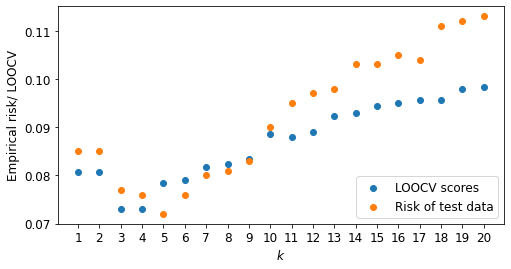

In [112]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(range(1,k+1), LOOCV_scores, label='LOOCV scores')
ax.scatter(range(1,k+1), test_small_risk, label='Risk of test data')
ax.legend(loc=4)
ax.set_xlabel(r"$k$")
ax.set_ylabel("Empirical risk/ LOOCV")
ax.xaxis.set_ticks(list(range(1,21)))

plt.savefig("Figures/ex_b_risk_LOOCV.pdf")
plt.show()



### Minkowski distances

In [59]:
def minkowski_distance(x, y, p):
    return np.sum(np.abs(x - y)**p, axis=1)**(1/p)

In [118]:
k_range = 20
p_range = 15
LOOCV_scores_minkowski_p = lambda p: cross_validation(images_train_small, numbers_train_small, k_range, lambda x,y: minkowski_distance(x,y,p))

LOOCV_scores_minkowski = np.array(list(map(LOOCV_scores_minkowski_p, range(1, p_range + 1))))

C:\Users\20192042\AppData\Local\Temp\ipykernel_19892\4219171555.py:2: RuntimeWarning: invalid value encountered in power
  return np.sum(np.abs(x - y)**p, axis=1)**(1/p)


In [158]:
def create_matrix(mat, xlab = "i", ylab = "j", mat_name = "S", dx = 0, dy = 0):

    nx = len(list(mat[0]))
    ny = len(list(mat))
    start = "\\begin{table}[H] \n\\centering \n\\begin{tabular}{l|" + "c" * nx + "} \\hline \n"

    header = f"\\backslashbox{{{ylab}}}{{{xlab}}} & " + " & ".join(list(map(str,range(1 + dx, dx + nx + 1)))) + " \\\\ \hline \n"

    add_middle = lambda i: str(i+1+dy) + " & " + " & ".join(list(map(str, mat[i]))) + " \\\\"

    middle = "\n".join(list(map(add_middle, range(ny))))

    end = "\n\\end{tabular}" + "\n\\end{table}"

    print(start + header + middle + end)

    return None


In [159]:
round_to_three = lambda x: "{:0.3f}".format(x)
round_to_three_list = lambda x: list(map(round_to_three, x))
LOOCV_scores_minkowski_rounded = list(map(round_to_three_list, LOOCV_scores_minkowski))
create_matrix([x[:10] for x in LOOCV_scores_minkowski_rounded], xlab = "$k$", ylab = "$p$")

\begin{table}[H] 
\centering 
\begin{tabular}{l|cccccccccc} \hline 
\backslashbox{$p$}{$k$} & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 \\ \hline 
1 & 0.090 & 0.090 & 0.090 & 0.083 & 0.091 & 0.090 & 0.097 & 0.091 & 0.097 & 0.097 \\
2 & 0.942 & 0.942 & 0.944 & 0.952 & 0.957 & 0.962 & 0.961 & 0.964 & 0.965 & 0.964 \\
3 & 0.750 & 0.750 & 0.735 & 0.715 & 0.697 & 0.681 & 0.677 & 0.664 & 0.656 & 0.646 \\
4 & 0.932 & 0.932 & 0.926 & 0.930 & 0.923 & 0.937 & 0.938 & 0.939 & 0.939 & 0.941 \\
5 & 0.904 & 0.904 & 0.903 & 0.892 & 0.882 & 0.884 & 0.882 & 0.879 & 0.879 & 0.877 \\
6 & 0.506 & 0.506 & 0.458 & 0.429 & 0.406 & 0.390 & 0.384 & 0.370 & 0.361 & 0.356 \\
7 & 0.946 & 0.946 & 0.946 & 0.957 & 0.944 & 0.965 & 0.965 & 0.964 & 0.963 & 0.961 \\
8 & 0.910 & 0.910 & 0.910 & 0.898 & 0.895 & 0.902 & 0.902 & 0.902 & 0.902 & 0.902 \\
9 & 0.712 & 0.712 & 0.689 & 0.669 & 0.667 & 0.648 & 0.639 & 0.627 & 0.611 & 0.611 \\
10 & 0.861 & 0.861 & 0.864 & 0.864 & 0.860 & 0.856 & 0.858 & 0.852 & 0.850 & 0.851 \\
11 & 

In [160]:
create_matrix([x[10:] for x in LOOCV_scores_minkowski_rounded], xlab = "$k$", ylab = "$p$", dx = 10)

\begin{table}[H] 
\centering 
\begin{tabular}{l|cccccccccc} \hline 
\backslashbox{$p$}{$k$} & 11 & 12 & 13 & 14 & 15 & 16 & 17 & 18 & 19 & 20 \\ \hline 
1 & 0.099 & 0.101 & 0.103 & 0.102 & 0.108 & 0.107 & 0.110 & 0.110 & 0.111 & 0.113 \\
2 & 0.966 & 0.969 & 0.971 & 0.972 & 0.973 & 0.974 & 0.976 & 0.980 & 0.978 & 0.977 \\
3 & 0.640 & 0.631 & 0.627 & 0.627 & 0.624 & 0.621 & 0.621 & 0.613 & 0.605 & 0.597 \\
4 & 0.944 & 0.941 & 0.942 & 0.946 & 0.949 & 0.950 & 0.956 & 0.964 & 0.963 & 0.959 \\
5 & 0.873 & 0.872 & 0.867 & 0.864 & 0.866 & 0.869 & 0.867 & 0.881 & 0.880 & 0.881 \\
6 & 0.339 & 0.339 & 0.331 & 0.328 & 0.323 & 0.317 & 0.311 & 0.307 & 0.298 & 0.299 \\
7 & 0.962 & 0.962 & 0.962 & 0.964 & 0.963 & 0.963 & 0.965 & 0.963 & 0.959 & 0.955 \\
8 & 0.903 & 0.903 & 0.903 & 0.903 & 0.901 & 0.901 & 0.904 & 0.923 & 0.922 & 0.922 \\
9 & 0.605 & 0.604 & 0.600 & 0.591 & 0.585 & 0.579 & 0.573 & 0.567 & 0.557 & 0.553 \\
10 & 0.852 & 0.851 & 0.849 & 0.845 & 0.837 & 0.841 & 0.845 & 0.843 & 0.841 & 0.842

In [163]:
# Index of minimum p and k
np.unravel_index(LOOCV_scores_minkowski.argmin(), LOOCV_scores_minkowski.shape)

(0, 3)

### Large sets

In [9]:
k = 20
neighbour_func_large = lambda img: k_nearest_neighbours(images_train, numbers_train, img, k, euclid_dist)

In [16]:
# less than 500 ms for 10000 test images is less than 5000 seconds
%timeit neighbour_func_large(images_test[0])

447 ms ± 21.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%%timeit
k = 20
img = images_test[0]
time_list = np.empty(10)

# Time dist
dist_time = perf_counter()
norm_list = euclid_dist(images_train, img)
dist_time = perf_counter() - dist_time
print(f"Dist time: {dist_time}")

nearest_idx = np.empty(k, dtype=np.int32)
common_nr = np.empty(k, dtype=np.int8)

# Time get nearest
nearest_time = perf_counter()
for i in range(k):
    min_idx = np.argmin(norm_list)
    norm_list[min_idx] = np.inf
    nearest_idx[i] = min_idx

    common_nr[i] = Counter(numbers_train[nearest_idx[:i+1]]).most_common(1)[0][0]
nearest_time = perf_counter() - nearest_time
print(f"Neasest k time: {nearest_time}")

# print(common_nr)

Dist time: 0.4067474000000857
Neasest k time: 0.0012456000000611311
Dist time: 0.49143629999991845
Neasest k time: 0.0023376999999982218
Dist time: 0.4948886999999331
Neasest k time: 0.0012935999999399428
Dist time: 0.4059293999999909
Neasest k time: 0.001276200000006611
Dist time: 0.41600419999997484
Neasest k time: 0.0012312000000065382
Dist time: 0.4217529000000013
Neasest k time: 0.00146349999999984
Dist time: 0.43385939999996026
Neasest k time: 0.00127569999995103
Dist time: 0.4564923999998882
Neasest k time: 0.0014170000000603977
447 ms ± 33.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
# Train data compared with test data
# Estimated completion time less than 5000 seconds
# test_common_nrs = np.array(list(map(neighbour_func_large, images_test))).transpose()

(16.0, 32.0, 48.0, 64.0, 80.0, 96.0, 112.0, 128.0, 144.0, 160.0, 176.0, 192.0, 208.0, 224.0, 240.0)
Counter({0: 627, 15: 64, 14: 12, 1: 11, 5: 9, 9: 8, 13: 8, 7: 6, 11: 6, 10: 6, 3: 5, 12: 5, 2: 5, 6: 4, 8: 4, 4: 4})


In [ ]:
# k_range = 20
# LOOCV_scores = cross_validation(images_train_small, numbers_train_small, k_range, euclid_dist)